In [2]:
# Standard Imports
import pandas as pd
%matplotlib inline 
import seaborn as sns; sns.set()
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib import pyplot


# Transformers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold


# Utilities
from numpy import absolute
from numpy import mean
from numpy import std
from numpy import arange

# Modeling Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report
from IPython.display import display, Markdown

from imblearn.under_sampling import RandomUnderSampler


In [3]:
X_train = pd.read_csv('../6-X_train_FINAL.csv')
X_test = pd.read_csv('../6-X_test_FINAL.csv')
X_train=X_train.drop(['MAKE', 'VIN'], axis=1)
X_test=X_test.drop(['MAKE', 'VIN'], axis=1)

In [4]:
# Dropping Nulls
X_train = X_train.dropna(axis=0)
X_test = X_test.dropna(axis=0)

In [5]:
X_train = X_train[X_train['GVW_TYPE'].notna()]
X_test = X_test[X_test['GVW_TYPE'].notna()]

X_train['GVW_TYPE'] = X_train['GVW_TYPE'].astype(int)
X_test['GVW_TYPE'] = X_test['GVW_TYPE'].astype(int)

X_train['VEHICLE_TYPE'] = X_train['VEHICLE_TYPE'].astype(str)
X_train['GVW_TYPE'] = X_train['GVW_TYPE'].astype(str)
X_train['FINAL_CYL'] = X_train['FINAL_CYL'].astype(str)
X_train['OBD_MIL_STATUS'] = X_train['OBD_MIL_STATUS'].astype(bool)

X_test['VEHICLE_TYPE'] = X_test['VEHICLE_TYPE'].astype(str)
X_test['GVW_TYPE'] = X_test['GVW_TYPE'].astype(str)
X_test['FINAL_CYL'] = X_test['FINAL_CYL'].astype(str)
X_test['OBD_MIL_STATUS'] = X_test['OBD_MIL_STATUS'].astype(bool)

In [6]:
X_train.OBD_MIL_STATUS.value_counts()


True     115712
False      3597
Name: OBD_MIL_STATUS, dtype: int64

In [7]:
# getting target feature
y_train = X_train['OVERALL_RESULT']
X_train = X_train.drop('OVERALL_RESULT', axis='columns')
y_train = LabelEncoder().fit_transform(y_train)

y_test = X_test['OVERALL_RESULT']
X_test = X_test.drop('OVERALL_RESULT', axis='columns')
y_test = LabelEncoder().fit_transform(y_test)

In [8]:
print(len(X_train))
print(len(y_train))

119309
119309


In [9]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    accuracy = accuracy_score(y,y_hat)
    f1 = f1_score(y,y_hat)
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show();

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report


def cross_validate(cv, balancing_technique, model,numerical_columns, categorical_columns = None):


    num_pipe = make_pipeline(
        StandardScaler(),
    )

    preprocessor_linear = make_column_transformer(
        (num_pipe, numerical_columns),
        n_jobs=2,
    )


    pipeline = make_pipeline(balancing_technique, model)

    if (categorical_columns != None) :
        print(':::::::CATEGORICAL FEATURES FOUND:::::::')
        cat_pipe = make_pipeline(
            OneHotEncoder(handle_unknown="ignore"),
        )

        preprocessor_linear = make_column_transformer(
            (num_pipe, numerical_columns),
            (cat_pipe, categorical_columns),
            n_jobs=2,
        )

        pipeline = make_pipeline(balancing_technique, preprocessor_linear, model)

    train_acc = []
    test_acc = []
    for train_ind, val_ind in cv.split(X_train, y_train):
        X_t, y_t = X_train.iloc[train_ind], y_train[train_ind]
        pipeline.fit(X_t, y_t)
        y_hat_t = pipeline.predict(X_t)
        train_acc.append(accuracy_score(y_t, y_hat_t))
        X_val, y_val = X_train.iloc[val_ind], y_train[val_ind]
        y_hat_val = pipeline.predict(X_val)
        test_acc.append(accuracy_score(y_val, y_hat_val))
    print(classification_report(y_val, y_hat_val))
    cm = confusion_matrix(y_val, y_hat_val)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    print('Training Accuracy: {}'.format(np.mean(train_acc)))
    print('\n')
    print('Validation Accuracy: {}'.format(np.mean(test_acc)))
    print('\n')



In [21]:
X_train

FINAL_CYL  CAR_AGE GVW_TYPE TRANS_TYPE DUAL_EXHAUST FUEL_TYPE  \
0              6     14.0        1          A            N         G   
1              6     10.0        1          A            N         G   
3              4     18.0        1          A            N         G   
4              6     16.0        1          A            N         G   
5              8     12.0        1          A            N         G   
...          ...      ...      ...        ...          ...       ...   
126739         6     17.0        1          A            N         G   
126741         4     18.0        1          M            N         G   
126742         4     16.0        1          A            N         G   
126743         8     19.0        1          A            N         G   
126744         4      7.0        1          M            N         G   

       VEHICLE_TYPE  OBD_MIL_STATUS  MODEL_YEAR  ODOMETER  AVG_MIL_YEARLY  
0                 1            True        2008   75042.0         10720.0  
1                 4            True        2012  105120.0         21024.0  
3                 1            True        2004  103911.0          8659.0  
4                 4            True        2006   86834.0         10152.0  
5                 3            True        2010  108221.0          9531.0  
...             ...             ...         ...       ...             ...  
126739            1            True        2005  154939.0         -2654.0  
126741            1            True        2004   89133.0          8913.0  
126742            2            True        2006  150295.0         11687.0  
126743            4            True        2003  196104.0         16342.0  
126744            2            True        2015   39835.0          9959.0  

[119309 rows x 11 columns]

# Using different balancing techniques

## Undersampling

:::::::CATEGORICAL FEATURES FOUND:::::::
              precision    recall  f1-score   support

           0       0.10      0.65      0.18      1511
           1       0.96      0.61      0.75     22350

    accuracy                           0.61     23861
   macro avg       0.53      0.63      0.46     23861
weighted avg       0.91      0.61      0.71     23861

Training Accuracy: 0.6644343796673298


Validation Accuracy: 0.616231756527502




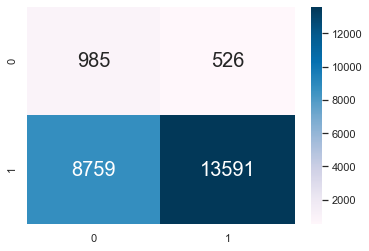

In [11]:
#Random Forest as model chosen
model = RandomForestClassifier(n_estimators=100, random_state=0)
#Balancing technique: UnderSampling
balancing_technique = RandomUnderSampler(random_state=0)
#Categorical features
categorical_columns = ['TRANS_TYPE','FUEL_TYPE', 'DUAL_EXHAUST', 'GVW_TYPE','VEHICLE_TYPE']

numerical_columns = ['CAR_AGE','MODEL_YEAR', 'ODOMETER', 'AVG_MIL_YEARLY']
#Evaluating the model
cross_validate(KFold(), balancing_technique, model,numerical_columns, categorical_columns)